In [141]:
import numpy as np
import pandas as pd

from statsmodels.stats.inter_rater import fleiss_kappa
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, log_loss, precision_recall_curve, auc, roc_auc_score, confusion_matrix, precision_score, f1_score, matthews_corrcoef, balanced_accuracy_score, cohen_kappa_score

with open("cross_val_HPO_stats_2.pkl", "rb") as f:
    data = pickle.load(f)

In [142]:
# Load predictions from training
path_to_predictions_final = "./results/training_run_20251217_224656_FINAL"
path_to_predictions =  "./results/training_run_20251217_224656"
ground_truth_path = "./training_data/ground_truth.npz"

seed = 43 # SAME AS WITH TRAINING: VERY IMPORTANT

preprocessing_names = [
    "normal", "CLAHE", "gray", "gray_CLAHE", "edges"
]
cropping_names = [
    "full", "hm", "vert", "od"
]

identifiers = [f"{processing}_{crop}" for processing in preprocessing_names for crop in cropping_names ]
print(identifiers)
prediction_sets_validation_final = []
prediction_sets_test_final = []

# Loading prediction sets from file
for ident in identifiers:
    prediction_path = f"{path_to_predictions_final}/{ident}/val_preds_fold_-1.npz"
    current_pred_set = np.load(prediction_path)
    prediction_sets_validation_final.append(current_pred_set["y_hat_val"])
    prediction_sets_test_final.append(current_pred_set["y_hat_test"])

assert len(prediction_sets_validation_final) == len(prediction_sets_test_final), "There should be an equal number of validation and test sets"

prediction_sets_validation = []
prediction_sets_test = []
for fold in range(10):
    curr_fold_val = []
    curr_fold_test = []
    for ident in identifiers:
        prediction_path = f"{path_to_predictions}/{ident}/val_preds_fold_{fold}.npz"
        current_pred_set = np.load(prediction_path)
        curr_fold_val.append(current_pred_set["y_hat_val"])
        curr_fold_test.append(current_pred_set["y_hat_test"])
    prediction_sets_validation.append(curr_fold_val)
    prediction_sets_test.append(curr_fold_test)
        

# Load ground truth
gt_dict = np.load(ground_truth_path)
y_full = gt_dict['y'].astype(int)

# Load pre-computed folds from file
fold_data = np.load("./training_data/data_split_indices.npz")

train_val_indices = fold_data['train_val_indices']
final_val_idx = fold_data['final_val_pos']
test_idx = fold_data['test_indices']

val_idx_list = [fold_data['fold_val_indices'][fold] for fold in range(10)]

# Filter arrays according to folds
y_val_list = [y_full[val_idx] for val_idx in val_idx_list]
final_y_val = y_full[final_val_idx]
y_test = y_full[test_idx]

N = len(train_val_indices)
print(f"N = {N}, positives = {(y_full[train_val_indices]==1).sum()}, negatives = {(y_full[train_val_indices]==0).sum()}")

['normal_full', 'normal_hm', 'normal_vert', 'normal_od', 'CLAHE_full', 'CLAHE_hm', 'CLAHE_vert', 'CLAHE_od', 'gray_full', 'gray_hm', 'gray_vert', 'gray_od', 'gray_CLAHE_full', 'gray_CLAHE_hm', 'gray_CLAHE_vert', 'gray_CLAHE_od', 'edges_full', 'edges_hm', 'edges_vert', 'edges_od']
N = 1130, positives = 565, negatives = 565


In [143]:
# print(data.keys())

optimizers = ["Bayesian_Binary", "Bayesian_Floating", "Genetic_Binary", "Genetic_Floating"]

bayesian_floating = data['Bayesian_Floating']
genetic_floating = data['Genetic_Floating']
bayesian_binary = data['Bayesian_Binary']
genetic_binary = data['Genetic_Binary']

# print(bayesian_floating.keys())

# bayesian_floating_weights_opt = bayesian_floating['best_val_test_weights']
# print(bayesian_floating[0]['best_val_test_weights'])
# bayesian_floating_weights = bayesian_floating['best_weights']
# print(bayesian_floating[0]['best_loss'])

In [134]:
from scipy.stats import t, sem

def ensemble_predictions(predictions, weights):
    return np.dot(weights, predictions)

def mean_ci(values, cfi=0.95):
    values = np.asarray(values)
    n = len(values)

    mean = values.mean()
    se = sem(values)
    t_val = t.ppf(cfi+(1-cfi)/2, df=n - 1)

    lower = mean - t_val * se
    upper = mean + t_val * se

    return mean, lower, upper

def get_average_and_ci(metrics_for_folds, metric, cfi=0.95):
    metric_list = [metrics_for_folds[i][metric] for i in range(len(metrics_for_folds))]
    mean, lower, upper = mean_ci(metric_list, cfi=cfi)
    return mean, lower, upper

In [135]:
print(np.array(prediction_sets_test_final).shape)
print(y_test.shape)

(20, 200)
(200,)


In [136]:
optimizer_metrics = {}
for optimizer in optimizers:
    raw_metric_list = []
    # for fold_idx in range(10):
    
    ensemble_preds = ensemble_predictions(prediction_sets_test_final, 
                                          data[optimizer]['best_val_test_weights'])
    raw_metrics = compute_metrics_small(y_test, ensemble_preds)
    raw_metric_list.append(raw_metrics)
    optimizer_metrics[optimizer] = raw_metric_list

TypeError: list indices must be integers or slices, not str

In [99]:
metrics = ['roc_auc', 'f1', 'recall', 'specificity']
rows = []
for optimizer in optimizers:
    row_dict = {'model': optimizer}
    for metric in metrics:
        mean, lower, upper = get_average_and_ci(optimizer_metrics[optimizer], metric)
        delta = upper - mean  # same as mean - lower
        metric_str = f"{mean:.3f}"
        
        row_dict[metric] = metric_str
    rows.append(row_dict)

df = pd.DataFrame(rows)
print(df.to_latex())

\begin{tabular}{llllll}
\toprule
 & model & roc_auc & f1 & recall & specificity \\
\midrule
0 & Bayesian_Binary & 0.822 & 0.735 & 0.720 & 0.760 \\
1 & Bayesian_Floating & 0.817 & 0.693 & 0.700 & 0.680 \\
2 & Genetic_Binary & 0.824 & 0.724 & 0.720 & 0.730 \\
3 & Genetic_Floating & 0.798 & 0.686 & 0.710 & 0.640 \\
\bottomrule
\end{tabular}



In [126]:
genetic_floating['best_val_test_weights']

array([1.4027785e-01, 2.8052328e-03, 1.4857112e-01, 5.4079092e-01,
       9.3830815e-03, 6.2957022e-04, 1.2348023e-02, 6.7256600e-02,
       1.1891025e-02, 3.2007457e-03, 3.1265772e-03, 4.0066916e-02,
       2.0285945e-03, 3.1703482e-03, 2.5760937e-03, 7.9580899e-03,
       1.3036793e-03, 8.8334444e-04, 1.5017408e-03, 2.3040199e-04],
      dtype=float32)

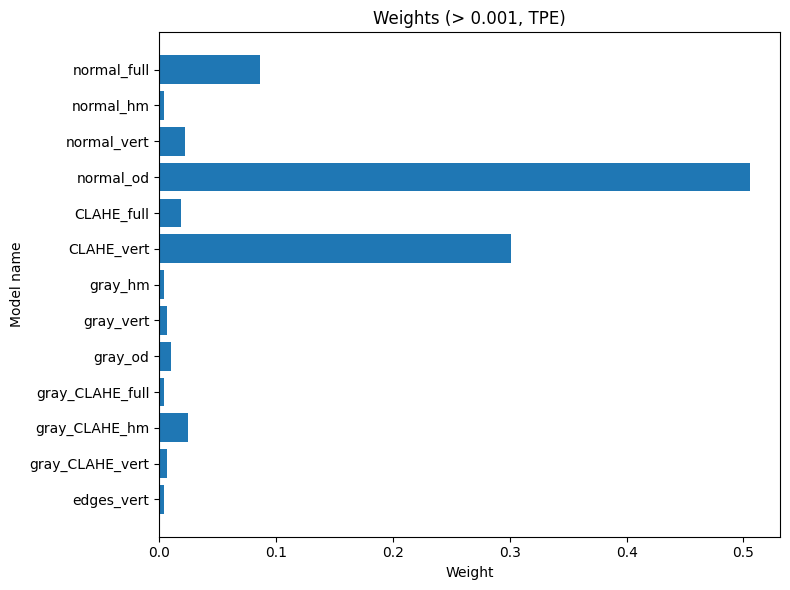

In [125]:
def plot_weights_single_fold(data, fold_idx=0, threshold=0.001):
    # Extract weights for a single fold
    weights = np.array(data['best_val_test_weights'])

    if len(identifiers) != weights.shape[0]:
        raise ValueError("Length of all_combinations must match number of weights")

    # Filter by threshold
    mask = weights > threshold
    filtered_weights = weights[mask]
    filtered_names = np.array(identifiers)[mask]

    y = np.arange(len(filtered_weights))

    plt.figure(figsize=(8, 6))
    plt.barh(y, filtered_weights, align="center")
    plt.yticks(y, filtered_names)
    plt.xlabel("Weight")
    plt.ylabel("Model name")
    plt.title("Weights (> 0.001, TPE)")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()



# Example usage:
plot_weights_single_fold(bayesian_floating, fold_idx=4)


In [139]:
bayesian_floating[0].keys()

dict_keys(['best_opt_loss', 'best_opt_weights', 'best_opt_trial_number', 'best_test_loss', 'best_test_weights', 'best_test_trial_number', 'best_opt_opt_metrics', 'best_opt_test_metrics', 'best_test_opt_metrics', 'best_test_test_metrics', 'opt_metrics', 'test_metrics'])

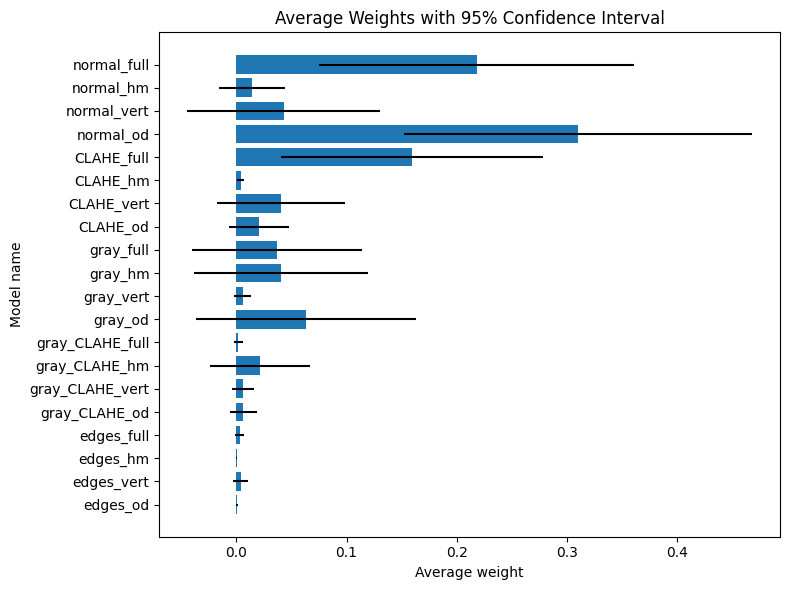

In [140]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem, t

def plot_average_weights_with_ci(data, confidence=0.95):
    # Extract weights into shape (num_runs, 20)
    weights = np.array([d['best_test_weights'] for d in data])

    n_runs, n_weights = weights.shape

    if len(identifiers) != n_weights:
        raise ValueError("Length of all_combinations must match number of weights")

    # Mean and SEM
    mean_weights = weights.mean(axis=0)
    se = sem(weights, axis=0)

    # t critical value
    t_val = t.ppf((1 + confidence) / 2.0, df=n_runs - 1)

    # Confidence interval half-width
    ci = t_val * se

    y = np.arange(n_weights)

    plt.figure(figsize=(8, 6))
    plt.barh(y, mean_weights, xerr=ci, align="center")
    plt.yticks(y, identifiers)
    plt.xlabel("Average weight")
    plt.ylabel("Model name")
    plt.title("Average Weights with 95% Confidence Interval")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


# Example usage:
plot_average_weights_with_ci(bayesian_floating)


In [26]:
def compute_auc_roc_pr_metrics(y_true: np.ndarray, y_pred: np.ndarray, num_thresholds: int = 100):
    thresholds = np.linspace(0.0, 1.0, num_thresholds)
    precision = np.zeros(num_thresholds)
    recall = np.zeros(num_thresholds)
    fpr = np.zeros(num_thresholds)
    tpr = np.zeros(num_thresholds)

    for i, t in enumerate(thresholds):
        y_pred_bin = (y_pred >= t).astype(int)

        TP = np.sum((y_true == 1) & (y_pred_bin == 1))
        FP = np.sum((y_true == 0) & (y_pred_bin == 1))
        FN = np.sum((y_true == 1) & (y_pred_bin == 0))
        TN = np.sum((y_true == 0) & (y_pred_bin == 0))

        precision[i] = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        recall[i] = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        fpr[i] = FP / (FP + TN) if (FP + TN) > 0 else 0.0
        tpr[i] = recall[i]  # TPR is the same as recall

    return precision, recall, fpr, tpr

# Helper functions
def compute_metrics(true_vals_binary, pred_probabilities, threshold=0.5):
    """Compute all classification metrics."""
    binary_preds = (pred_probabilities > threshold).astype(int)
    cm = confusion_matrix(true_vals_binary, binary_preds)
    
    TN = FP = FN = TP = -1
    if cm.shape == (2,2):
        TN, FP, FN, TP = cm.ravel()
    
    acc = accuracy_score(true_vals_binary, binary_preds)
    mcc = matthews_corrcoef(true_vals_binary, binary_preds)
    cohens_kappa_gt = cohen_kappa_score(true_vals_binary, binary_preds)
    roc_auc = roc_auc_score(true_vals_binary, pred_probabilities)
    
    precision_precise, recall_precise, _ = precision_recall_curve(true_vals_binary, pred_probabilities)
    pr_auc = auc(recall_precise, precision_precise)
    
    precision_100, recall_100, fpr_100, tpr_100 = compute_auc_roc_pr_metrics(true_vals_binary, pred_probabilities, num_thresholds=100)
    
    return {
        "accuracy": acc,
        "TN": TN,
        "FP": FP,
        "FN": FN,
        "TP": TP,
        "Precision (100 thresholds)": precision_100,
        "Recall (100 thresholds)": recall_100,
        "FPR (100 thresholds)": fpr_100,
        "TPR (100 thresholds)": tpr_100,
        "mcc": mcc,
        "cohens_kappa_gt": cohens_kappa_gt,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc
    }

def compute_metrics_small(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    return {
        "log_loss": log_loss(y_true, y_prob),
        "accuracy": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),          # sensitivity
        "specificity": tn / (tn + fp) if (tn + fp) > 0 else 0.0,
        "roc_auc": roc_auc_score(y_true, y_prob)
    }

def find_best_threshold(y_true, y_pred_probs, metric='accuracy', num_thresholds=101):
    thresholds = np.linspace(0, 1, num_thresholds)
    best_thresh = 0.5
    best_score = -np.inf
    
    for t in thresholds:
        y_pred_bin = (y_pred_probs >= t).astype(int)
        
        if metric == 'f1':
            score = f1_score(y_true, y_pred_bin)
        elif metric == 'accuracy':
            score = accuracy_score(y_true, y_pred_bin)
        elif metric == 'mcc':
            score = matthews_corrcoef(y_true, y_pred_bin)
        else:
            raise ValueError(f"Unsupported metric: {metric}")
        
        if score > best_score:
            best_score = score
            best_thresh = t
            
    return best_thresh, best_score